# <font color='darkblue'> Sparkify Small Dataset Models and Evaluation</font>

<div class="alert alert-block alert-info">

This notebook is dedicated to the following tasks:
    <li> , </li>
    <li> fea, </li>
    <li> EDAata, </li>
    <li> stratified split of the data into training and test sets </li>
    <li> feature relevance and feature selection considerations.</li>
</div>

## <font color='blue'>Set Environment</font>

In [1]:
# import PySpark libraries and packages

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, 
    first, last, 
    desc, asc,
    avg, count, countDistinct, 
    when, isnull, isnan,
    from_unixtime, 
    datediff,
    )

# libraries and packages for modeling

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.feature import (
    OneHotEncoder, 
    OneHotEncoderModel
)

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [51]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("Sparkify")
        .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")

In [3]:
# import python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# import library for enhanced plotting

import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette('PuBuGn_r')

## <font color='blue'>Load Train and Test Datasets</font>

In [6]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded...")
    
    return df


In [8]:
def save_data(df, data_path):
    """
    Saves the PySpark dataframe to a file.
    
    INPUT:
            df (PySpark dataframe) - data to be saved
            data_path (str) - path for datafile
    OUTPUT:
            none
    
    """
    
    df.write.json(data_path)

In [1]:
# path for the train set file
path_trainset = "data/mini_sparkify_train_data.json"

# upload the train data
df_train = load_data(path_trainset)

# check the upload
df_train.show(1, vertical=True)

NameError: name 'load_data' is not defined

In [10]:
# path for the test set file
path_testset = "data/mini_sparkify_test_data.json"

# upload the train data
df_test = load_data(path_testset)

# check the upload
df_test.show(1, vertical=True)

Loading the dataset ...


Dataset is loaded...
Cleaning the data ...
Dataset has 286500 rows initially.
Finished cleaning the data ...
Cleaned dataset has 278154 rows, 8346 rows were removed


### <font color='blue'>Toggle the memory</font>

In [62]:
# add the train set to the memory
train_cached = train_set.cache()

<div class="alert alert-block alert-info">

From the above bar plots it looks like the number of upgrades is an irrelevant feature to include, so we might drop it in the modeling phase. However, we must keep in mind that this conclusion is based on the mini data, and we have to check what happens with in the full data set case.
    
<div>

## <font color='blue'>Modeling</font>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### <font color='blue'>Build Pipeline</font>

In [89]:
# split the features and the label
CAT_FEATURES = ["gender", "level", "downgrade"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_playlist", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_home", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "avg_sess_h", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"


def build_pipeline(classifier):
    """
    Combines all the stages of the processing data. 
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the model to the pipeline
    stages += [classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

### <font color='blue'>Build Individual ML Pipelines</font>

In [ ]:
# train a Logistic Regression model
def logistic_regression_pipeline():
    lr_classifier = LogisticRegression(labelCol = "label",
                                       featuresCol = "features")
    return build_pipeline(lr_classifier)

# train a Decision Tree model
def decision_tree_pipeline():
    dt_classifier = DecisionTreeClassifier(labelCol = "label",
                                           featuresCol = "features",
                                           seed=1234)
    return build_pipeline(dt_classifier)

# train a Random Forest model
def random_forest_pipeline():
    rf_classifier = RandomForestClassifier(labelCol = "label",
                                           featuresCol = "features", 
                                           seed=1234)
    return build_pipeline(rf_classifier)

# train a Gradient-boosted Tree model
def gradient_boosted_pipeline():
    gbt_classifier = GBTClassifier(labelCol = "label",
                                   featuresCol = "features",
                                   seed=1234)
    return build_pipeline(gbt_classifier)

# train a Multilayer Perceptron Classifier
def multilayer_perceptron_pipeline():
    # specify layers: 23 (features), two intermediate (8, 4), output 2 (classes)
    layers=[23, 8, 4, 2]
    # create the trainer and set its parameters
    mlpc_classifier = MultilayerPerceptronClassifier(labelCol = "label",
                                                     featuresCol = "features",
                                                     layers=layers,
                                                     seed=1234)
    return build_pipeline(mlpc_classifier)

### <font color='blue'>Build K-Fold Cross Validation and Grid Search Pipelines</font>

In [34]:
# implement K-fold cross validation and grid search 

def grid_search_model(pipeline, param):
    """
    Creates a cross validation object.
    
    INPUT:
        param = grid of parameter
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    evaluator = BinaryClassificationEvaluator()
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=param,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

In [51]:
# model_name = "Logistic_Regression"
def lr_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_lr = ParamGridBuilder()
    param_lr = param_lr.addGrid(model.regParam, [.1, .5, 2]) #[.01])
    param_lr = param_lr.addGrid(model.elasticNetParam,  [.1, 1]) #[.5])
    param_lr = param_lr.build()
    
    print(f"Models trained: {len(param_lr)}")
    
    return grid_search_model(pipeline, param_lr)


# model_name = "Decision Trees"
def dt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_dt = ParamGridBuilder()
    param_dt = param_dt.addGrid(model.maxDepth, [5, 10, 15, 25]) #[25]) 
    param_dt = param_dt.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_dt = param_dt.build()
    
    print(f"Models trained: {len(param_dt)}")
    
    return grid_search_model(pipeline, param_dt)


# model_name = "Random Forest"
def rf_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_rf = ParamGridBuilder()
    param_rf = param_rf.addGrid(model.maxDepth, [10, 15, 25]) #[15]) 
    param_rf = param_rf.addGrid(model.maxBins, [8, 16, 32]) # [32]) 
    param_rf = param_rf.addGrid(model.numTrees, [20, 40, 60]) #[60])
    param_rf = param_rf.build()
    
    print(f"Models trained: {len(param_rf)}")
    
    return grid_search_model(pipeline, param_rf)


# model_name = "Gradient Boosted Trees"
def gbt_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_gbt = ParamGridBuilder()
    param_gbt = param_gbt.addGrid(model.maxDepth, [10, 15, 25]) #[15])
    param_gbt = param_gbt.addGrid(model.maxIter, [10, 20, 30]) #[20]) 
    param_gbt = param_gbt.addGrid(model.stepSize, [.05, .1]) #[.1])
    param_gbt = param_gbt.build()
    
    print(f"Models trained: {len(param_gbt)}")
    
    return grid_search_model(pipeline, param_gbt)


# model_name = "Multilayer Perceptron Classifier"
def mlpc_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    # create a list of parameters for Logistic Regression
    param_mlpc = ParamGridBuilder()
    param_mlpc = param_mlpc.addGrid(model.stepSize, [.01, .02,.05]) #[.02])
    param_mlpc = param_mlpc.addGrid(model.maxIter, [32, 64, 128, 256]) #[128])
    param_mlpc = param_mlpc.build()
    
    print(f"Models trained: {len(param_mlpc)}")
    
    return grid_search_model(pipeline, param_mlpc)

### <font color='blue'>Build Models Evaluators</font>

In [43]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==0)).count()
    tp = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==1)).count()                   
    fn = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==0)).count()                   
    fp = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [44]:
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[labelCol], dataset[predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)


## <font color='blue'>Train, Tune and Evaluate the Classifiers</font>

In [38]:
# split the data in training set and test set
train_set, test_set = split_data(df_feats)

In [39]:
train_set.persist(), test_set.persist()

(DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int],
 DataFrame[nr_songs: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_playlist: bigint, nr_friends: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_home: bigint, nr_error: bigint, nr_settings: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, avg_sess_h: double, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: int, tenure_days_interv: int, active_days: bigint, gender: int, level: int, downgrade: int, churn: int])

### <font color='blue'>Combine All Steps</font>

In [40]:
def train_evaluate_tune(model_name, classifier_pipeline, cv_pipeline):
    
    """
    The following steps are performed:
        - build the classifier,
        - run a grid search with cross validation, 
        - train the classifier on the train set,
        - build predictions on the test set,
        - compute and print training time and evaluation metrics
        
    INPUT:
        model_name (str)
        classifier_pipeline (pipeline object)
        cv_pipeline (cross validator)
    
    """
    
    print("")
    print("Training .....{}.".format(model_name))
    print("")
    
    # name the relevant columns
    predCol="prediction"
    labelCol="label"
    
    # build specific pipeline
    pipeline = classifier_pipeline()
    
    # choose an evaluator
    evaluator = BinaryClassificationEvaluator()
    evaluator.setLabelCol(labelCol)
    
    # build the grid search pipeline
    cv = cv_pipeline(pipeline)
    
    # start time
    start_time = time.time()
    
    # train the model
    model = cv.fit(train_set)
    
    # stop timer
    end_time = time.time()
    
    # evaluate the trainining time in minutes 
    train_time = (end_time - start_time)/60
    
    # print the training time
    print("")
    print("Training time.........%6.2f min" % train_time)
    
    # create the predictions dataset
    results = model.bestModel.transform(test_set)
    
    # calculate auc metric
    roc = evaluator.evaluate(results, {evaluator.metricName: "areaUnderROC"})
    pr = evaluator.evaluate(results, {evaluator.metricName: "areaUnderPR"})
    
    # print all other evaluation metrics
    print("")
    display_metrics(results)
    print("")

In [41]:
models_info = [["LOGISTIC REGRESSION CLASSIFIER", logistic_regression_pipeline, lr_grid_search],
          ["DECISION TREE CLASSIFIER", decision_tree_pipeline, dt_grid_search],
          ["RANDOM FOREST CLASSIFIER", random_forest_pipeline, rf_grid_search],
          ["GRADIENT BOOSTED TREES", gradient_boosted_pipeline, gbt_grid_search],
          ["MULTILAYER PERCEPTRON CLASSIFIER", multilayer_perceptron_pipeline, mlpc_grid_search]]

### <font color='blue'>Logistic Regression Classifier</font>

In [45]:
print("")
print(f"Training LOGISTIC REGRESSION CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = logistic_regression_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
lr = lr_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_lr = lr.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lr = model_lr.bestModel.transform(test_set)

# calculate auc metrics
roc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
pr_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lr, prec_lr, rec_lr, f1_lr = conf_metrics(predictions_lr)

# print all evaluation metrics
print("")
display_metrics(predictions_lr, roc_lr, pr_lr)
print("")

# print the best parameters from the grid
best_model_lr = model_lr.bestModel.stages[-1]
param_lr1 = best_model_lr.getRegParam()
param_lr2 = best_model_lr.getElasticNetParam()
print("The best hyperparameter values from the grid:")
print("regNetParam:..........", param_lr1)
print("elasticNetParam:......", param_lr2)


Training LOGISTIC REGRESSION CLASSIFIER

Models trained: 1


21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/23 15:21:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS



Training time......... 2.908 min




Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    9|
|  0.0|       1.0|    4|
|  1.0|       0.0|    4|
|  0.0|       0.0|   42|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 0.692
recall................. 0.692
F1..................... 0.692
auc_roc................ 0.851
auc_pr................. 0.698

The best hyperparameter values from the grid:
regNetParam:.......... 0.01
elasticNetParam:...... 0.5


### <font color='blue'>Decision Trees Classifier</font>

In [46]:
print("")
print(f"Training DECISION TREES CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = decision_tree_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
dt = dt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_dt = dt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_dt = model_dt.bestModel.transform(test_set)

# calculate auc metrics
roc_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
pr_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_dt, prec_dt, rec_dt, f1_dt = conf_metrics(predictions_dt)

# print all evaluation metrics
print("")
display_metrics(predictions_dt, roc_dt, pr_dt)
print("")

# print the best parameters from the grid
best_model_dt = model_dt.bestModel.stages[-1]
param_dt1 = best_model_dt.getMaxDepth()
param_dt2 = best_model_dt.getMaxBins()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_dt1)
print("maxBins:...........", param_dt2)


Training DECISION TREES CLASSIFIER

Models trained: 1

Training time......... 0.389 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.622
auc_pr................. 0.387

The best hyperparameter values from the grid:
maxDepth:.......... 25
maxBins:........... 32


### <font color='blue'>Random Forest Classifier</font>

In [47]:
print("")
print(f"Training RANDOM FOREST CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = random_forest_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
rf = rf_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_rf = rf.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_rf = model_rf.bestModel.transform(test_set)

# calculate auc metrics
roc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
pr_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_rf, prec_rf, rec_rf, f1_rf = conf_metrics(predictions_rf)

# print all evaluation metrics
print("")
display_metrics(predictions_rf, roc_rf, pr_rf)
print("")

best_param_rf = list(model_rf.getEstimatorParamMaps()[np.argmax(model_rf.avgMetrics)].values())
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", best_param_rf[0])
print("maxBins:...........", best_param_rf[1])
print("numTrees:..........", best_param_rf[2])


Training RANDOM FOREST CLASSIFIER

Models trained: 1



Training time......... 1.196 min




Confusion Matrix


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    5|
|  1.0|       0.0|    8|
|  0.0|       0.0|   46|
+-----+----------+-----+


accuracy............... 0.864
precision.............. 1.000
recall................. 0.385
F1..................... 0.556
auc_roc................ 0.746
auc_pr................. 0.645

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxBins:........... 32
numTrees:.......... 60


### <font color='blue'>Gradient Boosted Trees</font>

In [48]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = gradient_boosted_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
gbt = gbt_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.bestModel.transform(test_set)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

# print all evaluation metrics
print("")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

# print the best parameters from the grid
best_model_gbt = model_gbt.bestModel.stages[-1]
param_gbt1 = best_model_gbt.getMaxDepth()
param_gbt2 = best_model_gbt.getMaxIter()
param_gbt3 = best_model_gbt.getStepSize()
print("The best hyperparameter values from the grid:")
print("maxDepth:..........", param_gbt1)
print("maxIter:...........", param_gbt2)
print("stepSize:..........", param_gbt3)


Training GRADIENT BOOSTED TREES

Models trained: 1

Training time......... 5.043 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    6|
|  0.0|       1.0|   12|
|  1.0|       0.0|    7|
|  0.0|       0.0|   34|
+-----+----------+-----+


accuracy............... 0.678
precision.............. 0.333
recall................. 0.462
F1..................... 0.387
auc_roc................ 0.650
auc_pr................. 0.288

The best hyperparameter values from the grid:
maxDepth:.......... 15
maxIter:........... 20
stepSize:.......... 0.1


### <font color='blue'>Multilayer Perceptron Classifier</font>

In [49]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

predCol="prediction"
labelCol="label"

# build specific pipeline
pipeline = multilayer_perceptron_pipeline()

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# build the grid search pipeline
mlpc = mlpc_grid_search(pipeline)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_set)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.bestModel.transform(test_set)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

# print the best parameters from the grid
best_model_mlpc = model_mlpc.bestModel.stages[-1]
param_mlpc1 = best_model_mlpc.getStepSize()
param_mlpc2 = best_model_mlpc.getMaxIter()
param_mlpc3 = best_model_mlpc.getBlockSize()
print("The best hyperparameter values from the grid:")
print("stepSize:..........", param_mlpc1)
print("maxIter:...........", param_mlpc2)
print("blockSize:.........", param_mlpc3)


Training MULTILAYER PERCEPTRON CLASSIFIER

Models trained: 1

Training time......... 3.065 min


Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    7|
|  0.0|       1.0|   10|
|  1.0|       0.0|    6|
|  0.0|       0.0|   36|
+-----+----------+-----+


accuracy............... 0.729
precision.............. 0.412
recall................. 0.538
F1..................... 0.467
auc_roc................ 0.724
auc_pr................. 0.411

The best hyperparameter values from the grid:
stepSize:.......... 0.02
maxIter:........... 128
blockSize:......... 128


## <font color='blue'>Discuss the Best Model</font>

In [53]:
# create Pandas dataframe with metrics
dict_metrics = {"LinReg": [acc_lr, prec_lr, rec_lr, f1_lr, roc_lr, pr_lr],
                "DecTrees": [acc_dt, prec_dt, rec_dt, f1_dt, roc_dt, pr_dt], 
                "RandForest": [acc_rf, prec_rf, rec_rf, f1_rf, roc_rf, pr_rf],
                "GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

,LinReg,DecTrees,RandForest,GradBoost,MultiLPerceptron
list_metrics,,,,,
accuracy,0.864,0.678,0.864,0.678,0.729
precision,0.692,0.333,1.000,0.333,0.412
recall,0.692,0.462,0.385,0.462,0.538
f1_score,0.692,0.387,0.556,0.387,0.467
auc_roc,0.851,0.622,0.746,0.650,0.724
auc_pr,0.698,0.387,0.645,0.288,0.411


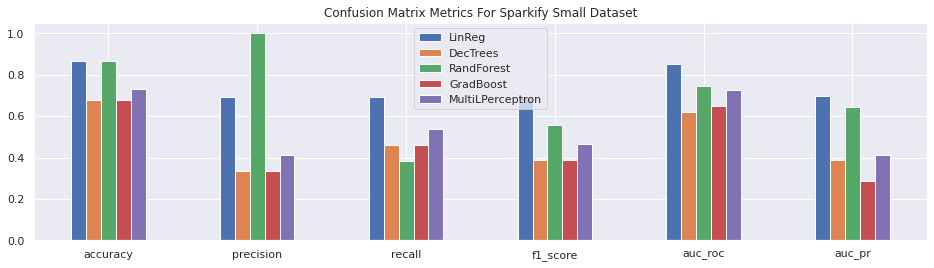

In [54]:
# adjust figure size and font size
sns.set(rc = {"figure.figsize":(16,4)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["LinReg", "DecTrees", "RandForest", "GradBoost", "MultiLPerceptron"], rot=0)

# create title and labels
plt.title("Confusion Matrix Metrics For Sparkify Small Dataset")
ax.set_xlabel("");
ax.set_ylabel("");